# Word Level Federated Text Generation with Stack Overflow with and without Pretrained Word Embeddings
- 02-07-20

**About:**

This notebook loads the Stack Overflow data available through `tff.simulation.datasets` and trains an LSTM model with Federared Averaging by following the Federated Learning for Text Generation [example notebook](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb).  The embedding layer in the LSTM is optionally initialized with either GloVe or FastText Embeddings.

**Notes:**

- This notebook prepares the Stack Overflow dataset for word level language modeling using this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
).
- The metrics for model training come from this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py). 


**Data:** 
- https://www.kaggle.com/stackoverflow/stackoverflow

**License:** 
- https://creativecommons.org/licenses/by-sa/3.0/

**Data and Model References:**
- https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/stackoverflow/load_data
- https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb
- https://github.com/tensorflow/federated/tree/master/tensorflow_federated/python/research/baselines/stackoverflow
- https://www.tensorflow.org/tutorials/text/text_generation

**Environment Setup References:**
- https://www.tensorflow.org/install/gpu
- https://gist.github.com/matheustguimaraes/43e0b65aa534db4df2918f835b9b361d
- https://www.tensorflow.org/install/source#tested_build_configurations
- https://anbasile.github.io/programming/2017/06/25/jupyter-venv/

### Environment Setup
Pip install these packages in the order listed.

In [1]:
# !pip install --upgrade pip
# !pip install --upgrade tensorflow-federated
# !pip tensorflow
# !pip install --upgrade tensorflow-gpu==2.0
# !pip install --upgrade nltk
# !pip install matplotlib
# !pip install nest_asyncio

### Imports

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import os, sys, io
sys.path.append(os.path.dirname(os.getcwd()))

In [4]:
import collections
import functools
import six
import time
import string

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_federated as tff

In [5]:
import src.dataset as dataset
import src.metrics as metrics
import src.embeddings as embeddings
import src.model as model
import src.validation as validation
import src.federated as federated
import src.generate_text as generate_text

### Set Compatability Behavior

In [6]:
tf.compat.v1.enable_v2_behavior()

### Check Tensorflow Install

In [7]:
print('Built with Cuda: {}'.format(tf.test.is_built_with_cuda()))
print('Build with GPU support: {}'.format(tf.test.is_built_with_gpu_support()))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Built with Cuda: True
Build with GPU support: True
Num GPUs Available:  1


### Set Tensorflow to Use GPU, unless GPU isn't available (which is the case for me)

In [8]:
physical_devices = tf.config.experimental.list_physical_devices(device_type=None)
tf.config.experimental.set_memory_growth(physical_devices[-1], enable=True)
for device in physical_devices:
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Test TFF

In [9]:
tff.federated_computation(lambda: 'Hello, World!')()

'Hello, World!'

### Set Some Parameters for Preprocessing the Data and Training the Model
**Note:** Ask Keith how he's been setting there for internal experiments.

In [10]:
VOCAB_SIZE = 10000
BATCH_SIZE = 16
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 20
MAX_ELEMENTS_PER_USER = 5000
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 1000
NUM_VALIDATION_EXAMPLES = 10000
NUM_TEST_EXAMPLES = 2

NUM_ROUNDS = 5
NUM_TRAIN_CLIENTS = 10

EMBEDDING_DIM = 300
EMBEDDING_PATH = ''
#EMBEDDING_PATH = f'../word_embeddings/glove/glove.6B.{EMBEDDING_DIM}d.txt'
#EMBEDDING_PATH = f'../word_embeddings/fasttext/wiki-news-{EMBEDDING_DIM}d-1M.vec'
EMBEDDING_PATH = f'../word_embeddings/fasttext/crawl-{EMBEDDING_DIM}d-2M.vec'


RNN_UNITS = 256

### Load and Preprocess Word Level Datasets

In [11]:
train_data, val_data, test_data = dataset.construct_word_level_datasets(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    client_epochs_per_round=CLIENTS_EPOCHS_PER_ROUND,
    max_seq_len=MAX_SEQ_LENGTH,
    max_elements_per_user=MAX_ELEMENTS_PER_USER,
    centralized_train=CENTRALIZED_TRAIN,
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    num_validation_examples=NUM_VALIDATION_EXAMPLES,
    num_test_examples=NUM_TEST_EXAMPLES)

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Retrieve the Dataset Vocab

In [12]:
vocab = dataset.get_vocab(vocab_size=VOCAB_SIZE)

### Retrieve the Special Characters Created During Preprocessing
The four special tokens are:
- pad: padding token
- oov: out of vocabulary
- bos: begin of sentence
- eos: end of sentence

In [13]:
pad, oov, bos, eos = dataset.get_special_tokens(vocab_size=VOCAB_SIZE)

In [14]:
special2idx = dict(zip(['pad', 'oov', 'bos', 'eos'], [pad, oov, bos, eos]))
idx2special = {v:k for k, v in special2idx.items()}

### Set Vocabulary
Add one to account for the pad token which has idx 0.

In [15]:
word2idx = {word:i+1 for i, word in enumerate(vocab)}
idx2word = {i+1:word for i, word in enumerate(vocab)}

### Add Special Characters

In [16]:
word2idx = {**word2idx, **special2idx}
idx2word = {**idx2word, **idx2special}

### Reset Vocab Size
This accounts for having added the special characters.

In [17]:
EXTENDED_VOCAB_SIZE = VOCAB_SIZE + len(special2idx)

### Load Pretrained Word Embeddings
- Either [GloVe embeddings from Stanford](https://nlp.stanford.edu/projects/glove/) - license [here](https://www.opendatacommons.org/licenses/pddl/1.0/)
- Or [FastText embeddings from Facebook](https://fasttext.cc/docs/en/english-vectors.html) - license [here](https://creativecommons.org/licenses/by-sa/3.0/)

### Create Embedding Matrix from Words in Word Index and Word Embeddings
If `EMBEDDING_PATH` is an empy string, the embedding matrix in the embedding layer is initialized according to the random uniform distribution used by the tf.keras embedding layer by passing the 'uniform' string as an argument to the `embedding_initializer` in the `build_model` function.

In [18]:
if EMBEDDING_PATH:
    embedding_matrix=embeddings.create_matrix_from_pretrained_embeddings(
        embedding_path=EMBEDDING_PATH,
        embedding_dim=EMBEDDING_DIM,
        word2idx=word2idx)
else:
    embedding_matrix = 'uniform'

/home/joel_stremmel/Documents/dev_gear/git/fl-text-models/src/embeddings.py:64: UserWarning: Words from dataset with no embedding: 461
  warnings.warn(f'Words from dataset with no embedding: {missing_words}')


### Load or Build the Model and Try Generating Some Text

In [19]:
keras_model = model.build_model(extended_vocab_size=EXTENDED_VOCAB_SIZE,
                                embedding_dim=EMBEDDING_DIM,
                                embedding_matrix=embedding_matrix,
                                rnn_units=RNN_UNITS)

generate_text.generate_text(model=keras_model,
                            word2idx=word2idx,
                            idx2word=idx2word,
                            start_string='How are you today')

"how are you today android's select2 contributing exponential node's dumb panels tasks activities availability resumes integrity charge vote snippets object fixtures touch symlink ndk alphabetical useful ask downs fiddling specifiers risky icloud insufficient relying instruction sdk notation likewise eliminate balanced cf dicts sdl rebuild cheers classify generic decryption getname font-face scenarios floating messages ns"

### Create TFF Version of the Model to be Trained with Federated Averaging
- TFF uses a sample batch so it knows the types and shapes that your model expects.
- The model function then builds and compiles the model and creates a TFF version to be trained.

In [20]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(val_data)))

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Initialize Train and Validation Model Trackers to be Used Below

In [21]:
evaluation_metric_names = ['loss',
                           'num_tokens',
                           'num_tokens_no_oov',
                           'num_batches',
                           'num_examples',
                           'accuracy',
                           'accuracy_no_oov',
                           'accuracy_no_oov_no_oes']

train_metrics_tracker = validation.model_history_tracker(metric_names=evaluation_metric_names)
val_metrics_tracker = validation.model_history_tracker(metric_names=evaluation_metric_names)

### Set the Default Executor

In [22]:
tff.framework.set_default_executor(tff.framework.create_local_executor(max_fanout=10))

### Create an Iterative Process

In [23]:
iterative_process = (
      tff.learning.federated_averaging.build_federated_averaging_process(
          model_fn=lambda : model.model_fn(extended_vocab_size=EXTENDED_VOCAB_SIZE,
                        embedding_dim=EMBEDDING_DIM,
                        embedding_matrix=embedding_matrix,
                        rnn_units=RNN_UNITS,
                        vocab_size=VOCAB_SIZE,
                        sample_batch=sample_batch),
          server_optimizer_fn=federated.server_optimizer_fn,
          client_weight_fn=federated.client_weight_fn))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Initalize the Process
Server state will be updated in the training loop.

In [24]:
server_state = iterative_process.initialize()

### Train Model Across Many Randomly Sampled Clients with Federated Averaging

Evaluating before training round #0 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 202ms/step - loss: 6.6126 - num_tokens: 136837.0000 - num_tokens_no_oov: 132590.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 4.3848e-05 - accuracy_no_oov: 4.5252e-05 - accuracy_no_oov_no_eos: 4.7813e-05
Sampling 10 new clients.
Round: 0
   Loss: 5.98092365
   num_batches: 221
   num_examples: 3462
   num_tokens: 44269
   num_tokens_no_oov: 43117
   accuracy: 0.02227
   accuracy_no_oov: 0.02287
Evaluating before training round #1 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 203ms/step - loss: 6.2785 - num_tokens: 129509.0000 - num_tokens_no_oov: 125603.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 6.1000e-04 - accuracy_no_oov: 3.5827e-04 - accuracy_no_oov_no_eos: 3.8059e-04
Sampling 10 new clients.
Round: 1
   Loss: 5.51981735
   num_batches: 319
   num_examples: 5055
   num_tokens: 73284
   num_tokens_no_oov: 71574
   accuracy: 0.03492
   accuracy_no_oov: 0.03571
Evaluating before training round #2 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 215ms/step - loss: 6.8316 - num_tokens: 142890.0000 - num_tokens_no_oov: 139119.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 9.0979e-04 - accuracy_no_oov: 6.2536e-04 - accuracy_no_oov_no_eos: 6.5586e-04
Sampling 10 new clients.
Round: 2
   Loss: 6.66170931
   num_batches: 117
   num_examples: 1807
   num_tokens: 23485
   num_tokens_no_oov: 22845
   accuracy: 0.00290
   accuracy_no_oov: 0.00298
Evaluating before training round #3 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 202ms/step - loss: 6.1467 - num_tokens: 127579.0000 - num_tokens_no_oov: 123365.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 3.1353e-05 - accuracy_no_oov: 1.6212e-05 - accuracy_no_oov_no_eos: 1.7294e-05
Sampling 10 new clients.
Round: 3
   Loss: 5.51531553
   num_batches: 131
   num_examples: 2031
   num_tokens: 24668
   num_tokens_no_oov: 23818
   accuracy: 0.00316
   accuracy_no_oov: 0.00327
Evaluating before training round #4 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 197ms/step - loss: 6.6382 - num_tokens: 140571.0000 - num_tokens_no_oov: 137079.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 4
   Loss: 5.04902792
   num_batches: 254
   num_examples: 3965
   num_tokens: 57549
   num_tokens_no_oov: 55728
   accuracy: 0.04097
   accuracy_no_oov: 0.04136


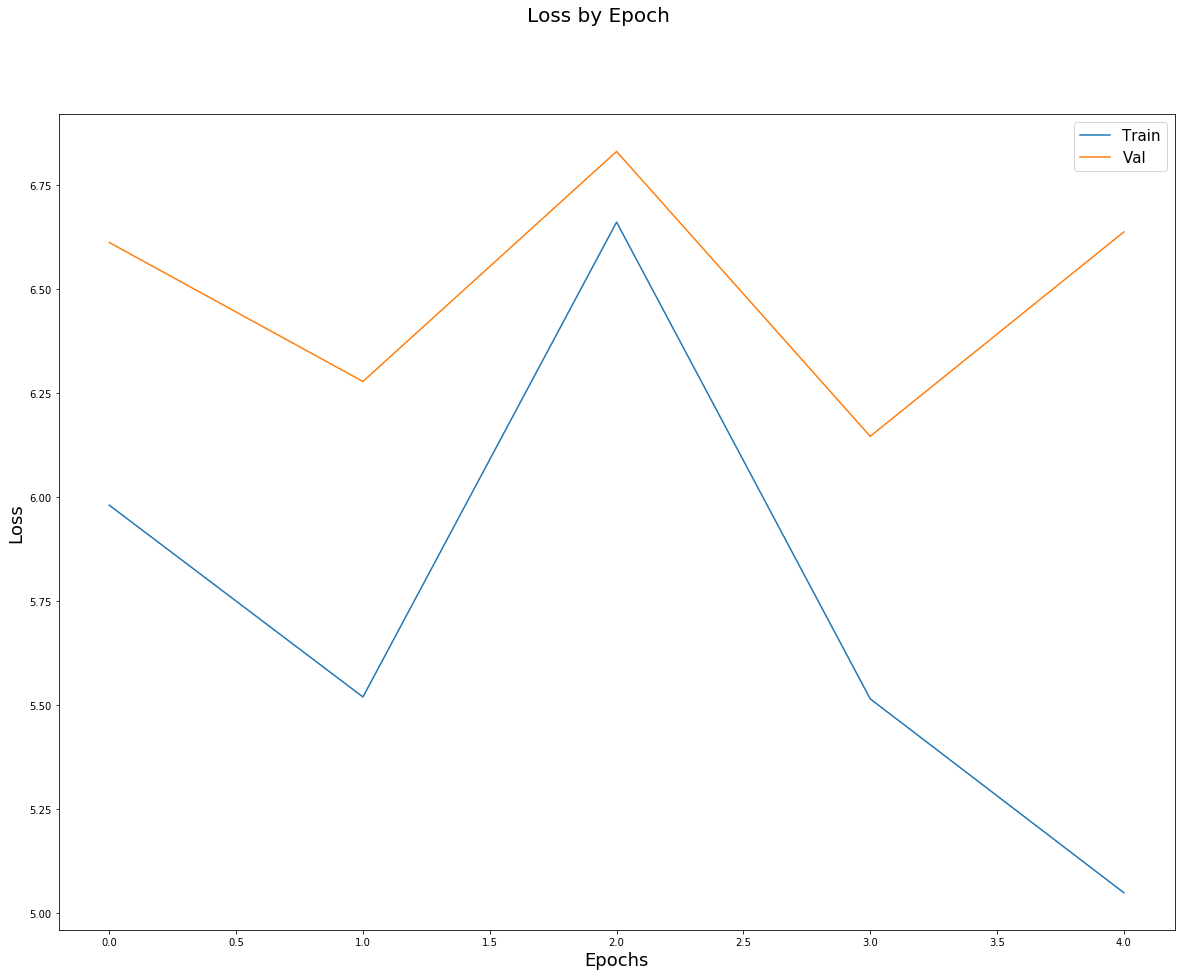

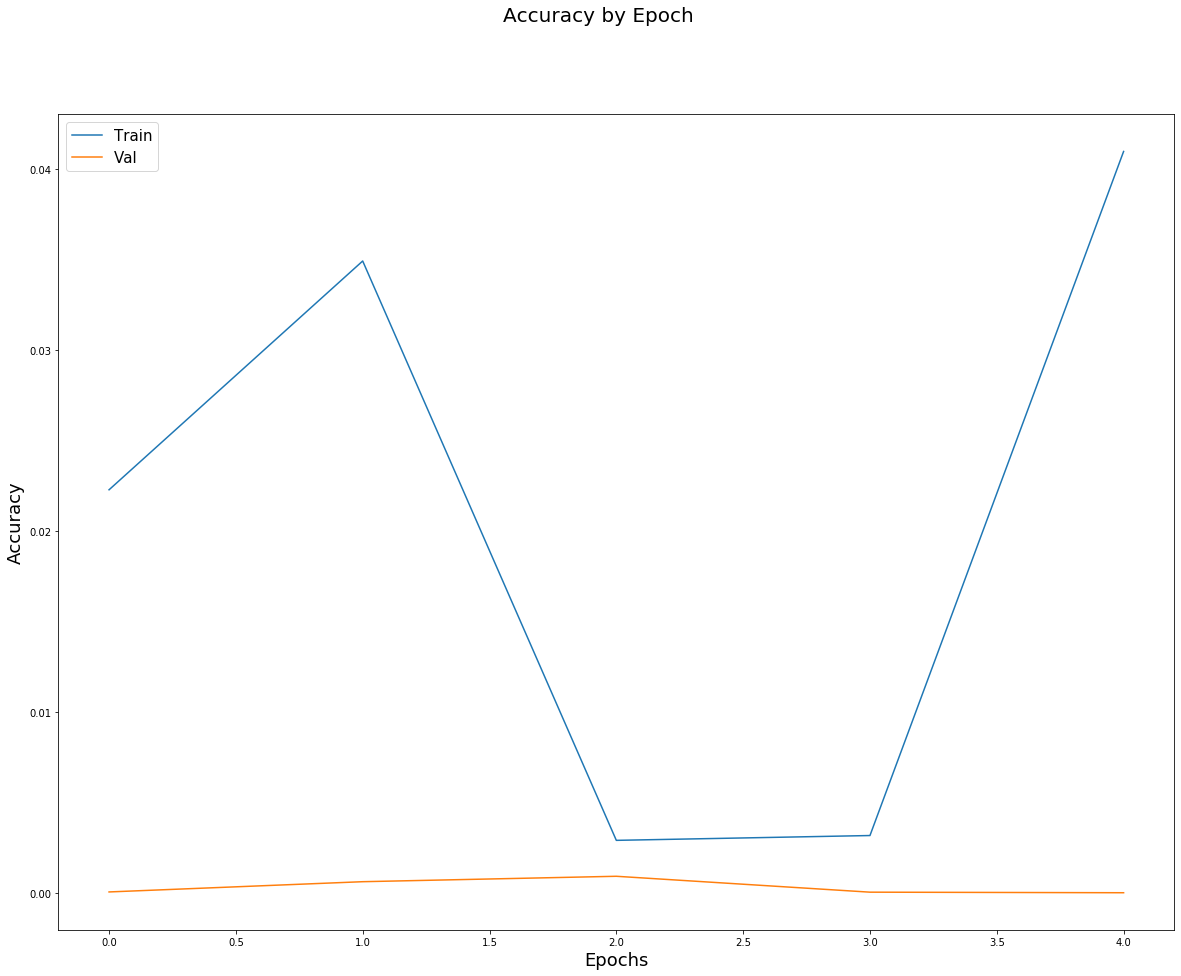

In [25]:
try:
    for round_num in range(0, NUM_ROUNDS):

        # Examine validation metrics
        print(f'Evaluating before training round #{round_num} on {NUM_VALIDATION_EXAMPLES} examples.')
        validation.keras_evaluate(state=server_state,
                                  val_dataset=val_data,
                                  extended_vocab_size=EXTENDED_VOCAB_SIZE,
                                  vocab_size=VOCAB_SIZE,
                                  embedding_dim=EMBEDDING_DIM,
                                  embedding_matrix=embedding_matrix,
                                  rnn_units=RNN_UNITS,
                                  metrics_tracker=val_metrics_tracker)

        # Sample train clients to create a train dataset
        print(f'Sampling {NUM_TRAIN_CLIENTS} new clients.')
        train_clients = federated.get_sample_clients(dataset=train_data, num_clients=NUM_TRAIN_CLIENTS)
        train_datasets = [train_data.create_tf_dataset_for_client(client) for client in train_clients]

        # Apply federated training round
        server_state, server_metrics = iterative_process.next(server_state, train_datasets)

        # Examine training metrics
        print('Round: {}'.format(round_num))
        print('   Loss: {:.8f}'.format(server_metrics.loss))
        print('   num_batches: {}'.format(server_metrics.num_batches))
        print('   num_examples: {}'.format(server_metrics.num_examples))
        print('   num_tokens: {}'.format(server_metrics.num_tokens))
        print('   num_tokens_no_oov: {}'.format(server_metrics.num_tokens_no_oov))
        print('   accuracy: {:.5f}'.format(server_metrics.accuracy))
        print('   accuracy_no_oov: {:.5f}'.format(server_metrics.accuracy_no_oov))

        # Add train metrics to tracker
        train_metrics_tracker.add_metrics_by_name('loss', server_metrics.loss)
        train_metrics_tracker.add_metrics_by_name('accuracy', server_metrics.accuracy)
        
        # Save loss and accuracy from train and validation sets
        np.save('train_loss.npy', train_metrics_tracker.get_metrics_by_name('loss'))
        np.save('val_loss.npy', val_metrics_tracker.get_metrics_by_name('loss'))
        np.save('train_accuracy.npy', train_metrics_tracker.get_metrics_by_name('accuracy'))
        np.save('val_accuracy.npy', val_metrics_tracker.get_metrics_by_name('accuracy'))

except KeyboardInterrupt as ke:
    
    print('Interrupted')
    
except:
    
    import traceback
    traceback.print_exc()
    
finally:
    
    fig, ax = plt.subplots(figsize=(20, 15))
    x_axis = range(0, NUM_ROUNDS)
    ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train')
    ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Val')
    ax.legend(loc='best', prop={'size': 15})
    fig.suptitle('Loss by Epoch', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.show()
    
    fig2, ax2 = plt.subplots(figsize=(20, 15))
    ax2.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train')
    ax2.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Val')
    ax2.legend(loc='best', prop={'size': 15})
    fig2.suptitle('Accuracy by Epoch', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.show()

### Load Loss and Accuracy Arrays

In [26]:
# train_loss_no_pt_embed = np.load('train_loss_no_pt_embed.npy')
# train_accuracy_no_pt_embed = np.load('train_accuracy_no_pt_embed.npy')
# val_loss_no_pt_embed = np.load('val_loss_no_pt_embed.npy')
# val_accuracy_no_pt_embed = np.load('val_accuracy_no_pt_embed.npy')

### Compare Model Loss

In [27]:
# fig, ax = plt.subplots(figsize=(20, 15))
# x_axis = range(0, NUM_ROUNDS)
# ax.plot(x_axis, train_loss_no_pt_embed, label='Train')
# ax.plot(x_axis, val_loss_no_pt_embed, label='Val')
# ax.plot(x_axis, train_metrics_tracker_with_embedding.get_metrics_by_name('loss'), label='Train with Glove')
# ax.plot(x_axis, val_metrics_tracker_with_embedding.get_metrics_by_name('loss'), label='Val with Glove')
# ax.legend(loc='best', prop={'size': 15})
# fig.suptitle('Model\'s Loss with number of epochs', fontsize=20)
# plt.xlabel('Epochs', fontsize=18)
# plt.ylabel('Loss', fontsize=18)
# fig.savefig('Loss_with_Epochs.jpg')
# plt.show()

### Compare Model Accuracy

In [28]:
# fig, ax = plt.subplots(figsize=(20, 15))
# x_axis = range(0, NUM_ROUNDS)
# ax.plot(x_axis, train_accuracy_no_pt_embed, label='Train')
# ax.plot(x_axis, val_accuracy_no_pt_embed, label='Val')
# ax.plot(x_axis, train_metrics_tracker_with_embedding.get_metrics_by_name('accuracy'), label='Train with Glove')
# ax.plot(x_axis, val_metrics_tracker_with_embedding.get_metrics_by_name('accuracy'), label='Val with Glove')
# ax.legend(loc='best', prop={'size': 15})
# fig.suptitle('Model\'s Accuracy with number of epochs', fontsize=20)
# plt.xlabel('Epochs', fontsize=18)
# plt.ylabel('Accuracy', fontsize=18)
# fig.savefig('Accuracy_with_Epochs.jpg')
# plt.show()